In [1]:
import pandas as pd
import numpy as np

# Set random seed
np.random.seed(100)

# Possible values
genders = ["Male", "Female", "Non-binary"]
departments = ["Sales", "Engineering", "HR", "Marketing", "Finance"]

# Create dataset
n = 1200
data = pd.DataFrame({
    "Employee_ID": range(1, n+1),
    "Age": np.random.randint(22, 65, n),
    "Gender": np.random.choice(genders, n, p=[0.50, 0.45, 0.05]),
    "Department": np.random.choice(departments, n, p=[0.25, 0.35, 0.15, 0.15, 0.10]),
    "Years_at_Company": np.random.randint(0, 30, n),
    "Performance_Score": np.random.randint(1, 6, n),  # 1 to 5
    "Current_Salary": np.random.randint(30, 200, n)  # in thousands
})

# Introduce a promotion pattern
data["Promoted"] = np.where(
    (data["Performance_Score"] >= 4) & (data["Years_at_Company"] >= 5),
    np.random.choice([1, 0], n, p=[0.75, 0.25]),
    np.random.choice([1, 0], n, p=[0.2, 0.8])
)

data.head()

,Employee_ID,Age,Gender,Department,Years_at_Company,Performance_Score,Current_Salary,Promoted
0,1,30,Female,Engineering,9,5,85,1
1,2,46,Female,HR,23,3,38,0
2,3,25,Female,Finance,26,3,179,0
3,4,61,Male,Sales,21,3,199,0
4,5,45,Male,Marketing,21,1,171,0


In [2]:
# Task 1 – Fairness
# Promotion rate by gender
gender_promotion = data.groupby("Gender")["Promoted"].mean() * 100
print("Promotion Rate by Gender (%):\n", gender_promotion)

# Promotion rate by department
dept_promotion = data.groupby("Department")["Promoted"].mean() * 100
print("\nPromotion Rate by Department (%):\n", dept_promotion)

Promotion Rate by Gender (%):
 Gender
Female        38.372093
Male          38.486312
Non-binary    34.920635
Name: Promoted, dtype: float64

Promotion Rate by Department (%):
 Department
Engineering    39.119804
Finance        36.111111
HR             39.784946
Marketing      34.444444
Sales          39.116719
Name: Promoted, dtype: float64


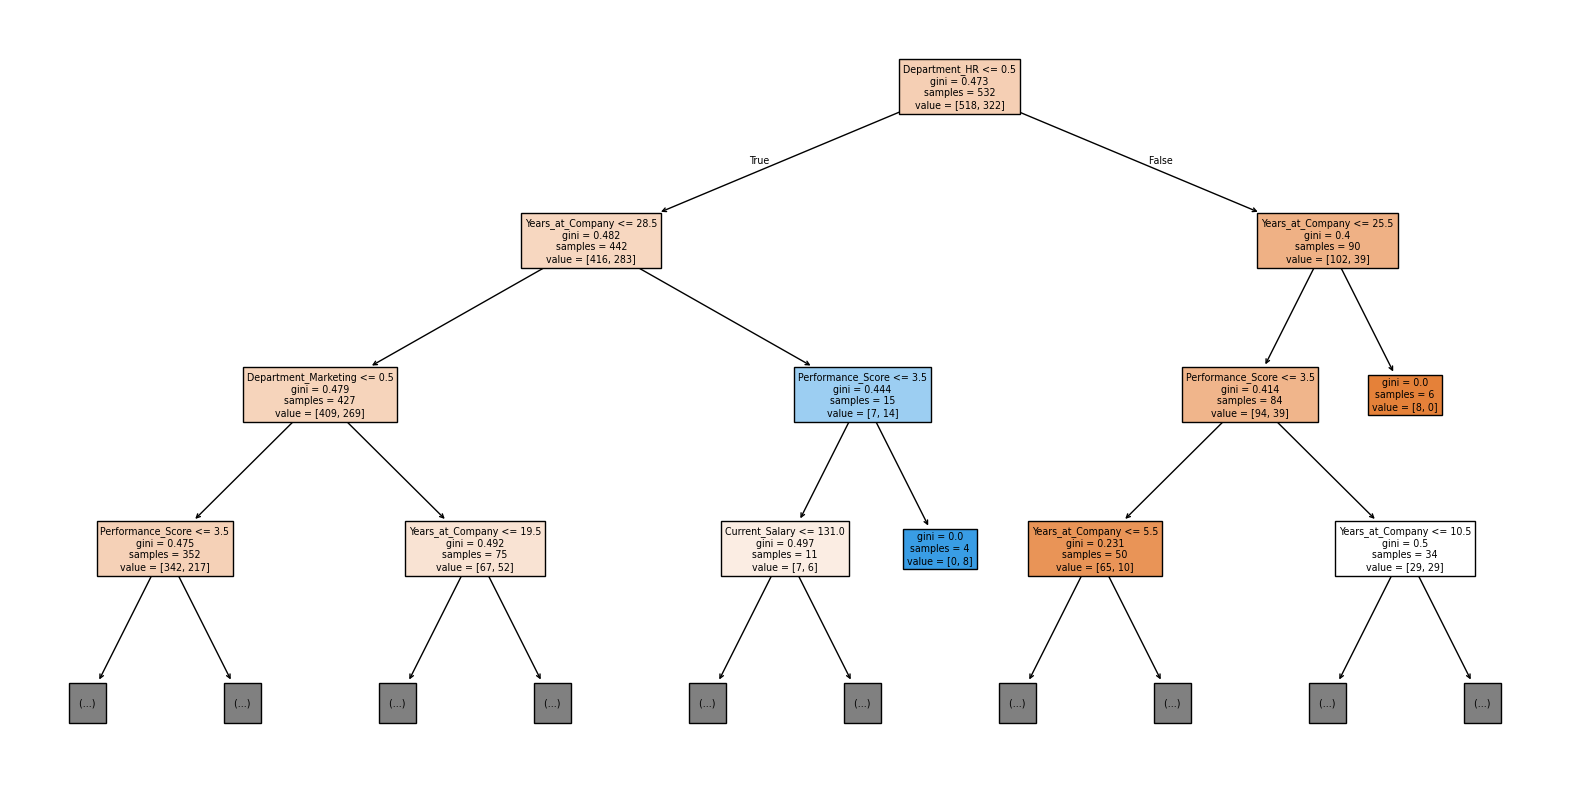

|--- Department_HR <= 0.50
|   |--- Years_at_Company <= 28.50
|   |   |--- Department_Marketing <= 0.50
|   |   |   |--- Performance_Score <= 3.50
|   |   |   |   |--- Current_Salary <= 159.50
|   |   |   |   |   |--- Years_at_Company <= 3.50
|   |   |   |   |   |   |--- Performance_Score <= 2.50
|   |   |   |   |   |   |   |--- Performance_Score <= 1.50
|   |   |   |   |   |   |   |   |--- Age <= 58.00
|   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |--- Age >  58.00
|   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |--- Performance_Score >  1.50
|   |   |   |   |   |   |   |   |--- Years_at_Company <= 2.50
|   |   |   |   |   |   |   |   |   |--- Department_Sales <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |   |--- Department_Sales >  0.50
|   |   |   |   |   |   |   |   |   |   |--- Gender_Male <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |

In [3]:
# Task 2 – Transparency
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_text, plot_tree
import matplotlib.pyplot as plt

# Prepare data
features = ["Age", "Gender", "Department", "Years_at_Company", "Performance_Score", "Current_Salary"]
X = pd.get_dummies(data[features], drop_first=True)
y = data["Promoted"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)

# Extract one tree for transparency
one_tree = rf.estimators_[0]

plt.figure(figsize=(20,10))
plot_tree(one_tree, feature_names=X.columns, filled=True, max_depth=3)
plt.show()

# Show text rules from one tree
print(export_text(one_tree, feature_names=list(X.columns)))

In [4]:

# Task 3 – Accountability
import datetime

log_records = []

def log_prediction(model, input_df):
    pred = model.predict(input_df)[0]
    timestamp = datetime.datetime.now().isoformat()
    log_entry = {
        "timestamp": timestamp,
        "input_data": input_df.to_dict(orient='records')[0],
        "prediction": int(pred)
    }
    log_records.append(log_entry)
    return pred

# Example logging of a single employee
sample_input = X_test.iloc[[0]]
log_prediction(rf, sample_input)
log_records[:2]  # Show first 2 logs

[{'timestamp': '2025-08-13T08:03:59.452034',
  'input_data': {'Age': 24,
   'Years_at_Company': 6,
   'Performance_Score': 4,
   'Current_Salary': 45,
   'Gender_Male': False,
   'Gender_Non-binary': True,
   'Department_Finance': False,
   'Department_HR': False,
   'Department_Marketing': False,
   'Department_Sales': False},
  'prediction': 1}]

In [5]:
# Task-4
# Anonymize Employee_ID
import hashlib

def hash_id(x):
    return hashlib.sha256(str(x).encode()).hexdigest()

data["Employee_ID"] = data["Employee_ID"].apply(hash_id)

data.head()

,Employee_ID,Age,Gender,Department,Years_at_Company,Performance_Score,Current_Salary,Promoted
0,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,30,Female,Engineering,9,5,85,1
1,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,46,Female,HR,23,3,38,0
2,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,25,Female,Finance,26,3,179,0
3,4b227777d4dd1fc61c6f884f48641d02b4d121d3fd328c...,61,Male,Sales,21,3,199,0
4,ef2d127de37b942baad06145e54b0c619a1f22327b2ebb...,45,Male,Marketing,21,1,171,0


In [ ]:
# Task 5 – Safety & Reliability
# Introduce bad records
data.loc[0, "Years_at_Company"] = -3
data.loc[1, "Performance_Score"] = 7  # invalid

# Validation
def validate_row(row):
    if row["Years_at_Company"] < 0 or not (1 <= row["Performance_Score"] <= 5):
        return False
    return True

invalid_rows = data[~data.apply(validate_row, axis=1)]
print("Invalid Rows Found:\n", invalid_rows)

In [6]:
# Task 6 – Inclusivity
# Representation by Gender
gender_counts = data["Gender"].value_counts(normalize=True) * 100
print("Gender Representation (%):\n", gender_counts)

# Representation by Department
dept_counts = data["Department"].value_counts(normalize=True) * 100
print("\nDepartment Representation (%):\n", dept_counts)

Gender Representation (%):
 Gender
Male          51.75
Female        43.00
Non-binary     5.25
Name: proportion, dtype: float64

Department Representation (%):
 Department
Engineering    34.083333
Sales          26.416667
HR             15.500000
Marketing      15.000000
Finance         9.000000
Name: proportion, dtype: float64


In [7]:
# fairness and metric comparison
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

print("RF Accuracy:", accuracy_score(y_test, rf.predict(X_test)))
print("LR Accuracy:", accuracy_score(y_test, lr_preds))

# Example fairness metric — Demographic Parity Difference by Gender
def demographic_parity(y_true, y_pred, sensitive_values):
    groups = pd.DataFrame({"y_true": y_true, "y_pred": y_pred, "group": sensitive_values})
    rates = groups.groupby("group")["y_pred"].mean()
    return rates.max() - rates.min()

dp_diff = demographic_parity(y_test, rf.predict(X_test),
                              data.iloc[y_test.index]["Gender"])
print(f"Demographic Parity Difference (RF): {dp_diff:.3f}")

RF Accuracy: 0.7472222222222222
LR Accuracy: 0.725
Demographic Parity Difference (RF): 0.185
